In [45]:
import geopandas as gpd
import pandas as pd
import numpy as np
from shapely.geometry import Point
from scipy.interpolate import griddata
from sklearn.linear_model import LogisticRegression
from sklearn.model_selection import train_test_split
from sklearn.metrics import classification_report, confusion_matrix, accuracy_score, roc_auc_score

# === Cargar shapefiles ===
gdf_depositos = gpd.read_file("C:/Git_SCA/AGE/Depositos").to_crs(epsg=4326)
gdf_moho = gpd.read_file("C:/Git_SCA/AGE/Corteza").to_crs(epsg=4326)
gdf_dataciones = gpd.read_file("C:/Git_SCA/AGE/Dataciones").to_crs(epsg=4326)
gdf_gradiente = gpd.read_file("C:/Git_SCA/AGE/Geotermica").to_crs(epsg=4326)

# === Generar pseudo-ausencias en todo el dominio espacial definido ===
gdf_depositos["Presencia"] = 1
num_depos = len(gdf_depositos)
rng = np.random.default_rng(42)
pseudo_points = []

while len(pseudo_points) < num_depos:
    x, y = rng.uniform(-80, -65), rng.uniform(-5, 15)
    pseudo_points.append(Point(x, y))

gdf_aus = gpd.GeoDataFrame(geometry=pseudo_points, crs="EPSG:4326")
gdf_aus["Presencia"] = 0

# === Unir datos y extraer coordenadas ===
gdf_total = pd.concat([gdf_depositos, gdf_aus], ignore_index=True)
gdf_total["X"] = gdf_total.geometry.x
gdf_total["Y"] = gdf_total.geometry.y

# === Crear grilla de interpolación ===
grid_x, grid_y = np.mgrid[-80:-65:500j, -5:15:500j]

# === Función para interpolar variable espacial ===
def interpolar(gdf, columna, grid_x, grid_y, filtro=None):
    gdf = gdf.copy()
    gdf[columna] = pd.to_numeric(gdf[columna].astype(str).str.replace(",", "."), errors="coerce")
    if filtro:
        gdf = gdf.query(filtro)
    coords = np.array([[p.x, p.y] for p in gdf.geometry])
    valores = gdf[columna].values
    grid = griddata(coords, valores, (grid_x, grid_y), method="cubic")
    grid[np.isnan(grid)] = griddata(coords, valores, (grid_x[np.isnan(grid)], grid_y[np.isnan(grid)]), method="nearest")
    return grid

# === Interpolaciones ===
grid_moho = interpolar(gdf_moho, "Z", grid_x, grid_y)
grid_edad = interpolar(gdf_dataciones, "EdadMa", grid_x, grid_y, "EdadMa <= 4000")
grid_grad = interpolar(gdf_gradiente, "GRADIENTE", grid_x, grid_y)

# === Función para extraer valor interpolado en punto ===
def sample_grid_value(x, y, grid, xmin=-80, xmax=-65, ymin=-5, ymax=15, n=500):
    ix = int((x - xmin) / ((xmax - xmin) / n))
    iy = int((ymax - y) / ((ymax - ymin) / n))
    if 0 <= ix < n and 0 <= iy < n:
        return grid[iy, ix]
    return np.nan

# === Aplicar valores interpolados al dataset ===
gdf_total["Moho_Z"] = gdf_total.apply(lambda r: sample_grid_value(r.X, r.Y, grid_moho), axis=1)
gdf_total["EdadMa"] = gdf_total.apply(lambda r: sample_grid_value(r.X, r.Y, grid_edad), axis=1)
gdf_total["Gradiente"] = gdf_total.apply(lambda r: sample_grid_value(r.X, r.Y, grid_grad), axis=1)

# === Filtrar por edad válida (EdadMa ≤ 4000) y sin nulos ===
gdf_modelo = gdf_total.dropna(subset=["Moho_Z", "EdadMa", "Gradiente"])
gdf_modelo = gdf_modelo[gdf_modelo["EdadMa"] <= 4000]

# === Modelo de regresión logística ===
X = gdf_modelo[["Moho_Z", "EdadMa", "Gradiente"]].values
y = gdf_modelo["Presencia"].values
X_train, X_test, y_train, y_test = train_test_split(X, y, stratify=y, test_size=0.3, random_state=42)

model = LogisticRegression(max_iter=1000)
model.fit(X_train, y_train)
y_pred = model.predict(X_test)
y_prob = model.predict_proba(X_test)[:, 1]

# === Evaluación del modelo ===
report = classification_report(y_test, y_pred, digits=3)
cmatrix = confusion_matrix(y_test, y_pred)
acc = accuracy_score(y_test, y_pred)
auc = roc_auc_score(y_test, y_prob)
coef = model.coef_[0]
intercept = model.intercept_[0]

# === Reporte ===
print(f"""
=== MODELO DE REGRESIÓN LOGÍSTICA ===

Variables predictoras:
 - Moho_Z (profundidad del Moho)
 - EdadMa (edad interpolada en millones de años, filtrada < 4000)
 - Gradiente (gradiente geotérmico interpolado)

--- MÉTRICAS DE EVALUACIÓN ---

Classification Report:
{report}

Confusion Matrix:
{cmatrix}

Accuracy: {acc:.3f}
AUC-ROC: {auc:.3f}

--- COEFICIENTES DEL MODELO ---

Intercept (log-odds base): {intercept:.6f}
Coeficiente Moho_Z:         {coef[0]:.6f}
Coeficiente EdadMa:         {coef[1]:.6f}
Coeficiente Gradiente:      {coef[2]:.6f}

Interpretación:
- Moho_Z tiene un efecto {'positivo' if coef[0] > 0 else 'negativo'} sobre la probabilidad de encontrar un depósito.
- EdadMa sugiere depósitos en zonas más {'antiguas' if coef[1] > 0 else 'jóvenes'}.
- Gradiente geotérmico tiene una influencia {'positiva' if coef[2] > 0 else 'negativa'} sobre la ocurrencia.
""")



=== MODELO DE REGRESIÓN LOGÍSTICA ===

Variables predictoras:
 - Moho_Z (profundidad del Moho)
 - EdadMa (edad interpolada en millones de años, filtrada < 4000)
 - Gradiente (gradiente geotérmico interpolado)

--- MÉTRICAS DE EVALUACIÓN ---

Classification Report:
              precision    recall  f1-score   support

           0      0.904     0.699     0.789       256
           1      0.762     0.929     0.837       266

    accuracy                          0.816       522
   macro avg      0.833     0.814     0.813       522
weighted avg      0.832     0.816     0.813       522


Confusion Matrix:
[[179  77]
 [ 19 247]]

Accuracy: 0.816
AUC-ROC: 0.883

--- COEFICIENTES DEL MODELO ---

Intercept (log-odds base): -4.705854
Coeficiente Moho_Z:         0.085540
Coeficiente EdadMa:         0.001196
Coeficiente Gradiente:      0.000067

Interpretación:
- Moho_Z tiene un efecto positivo sobre la probabilidad de encontrar un depósito.
- EdadMa sugiere depósitos en zonas más antiguas.
- 

=== MATRIZ DE CORRELACIÓN ===
             Moho_Z    EdadMa  Gradiente
Moho_Z     1.000000  0.207227   0.042639
EdadMa     0.207227  1.000000   0.007823
Gradiente  0.042639  0.007823   1.000000


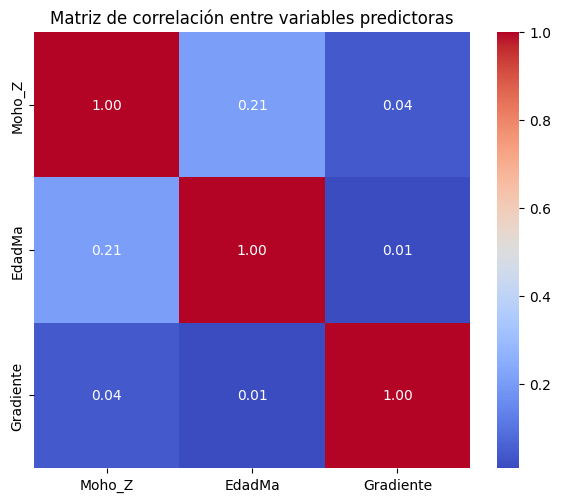

In [46]:
import seaborn as sns
import matplotlib.pyplot as plt

# === Seleccionar solo las tres variables ===
variables_corr = gdf_modelo[["Moho_Z", "EdadMa", "Gradiente"]]

# === Calcular la matriz de correlación ===
matriz_corr = variables_corr.corr(method="pearson")  # Puedes cambiar a "spearman" si lo deseas

print("=== MATRIZ DE CORRELACIÓN ===")
print(matriz_corr)

# === Visualizar con mapa de calor ===
plt.figure(figsize=(6, 5))
sns.heatmap(matriz_corr, annot=True, cmap="coolwarm", fmt=".2f", square=True)
plt.title("Matriz de correlación entre variables predictoras")
plt.tight_layout()
plt.show()


=== MATRIZ DE CORRELACIÓN ===
           Presencia    EdadMa    Moho_Z  Gradiente
Presencia   1.000000  0.467170  0.399393   0.059013
EdadMa      0.467170  1.000000  0.207227   0.007823
Moho_Z      0.399393  0.207227  1.000000   0.042639
Gradiente   0.059013  0.007823  0.042639   1.000000


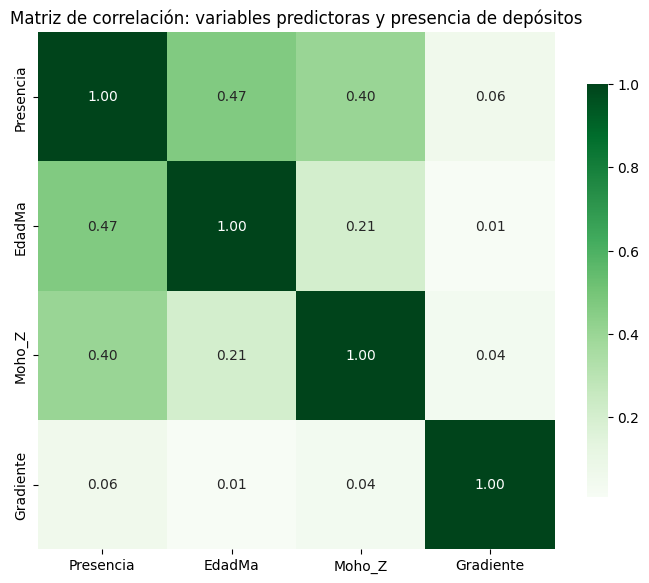

In [47]:
import seaborn as sns
import matplotlib.pyplot as plt

# === Seleccionar las variables predictoras y la respuesta ===
variables_corr = gdf_modelo[[ "Presencia", "EdadMa","Moho_Z","Gradiente"]]

# === Calcular la matriz de correlación ===
matriz_corr = variables_corr.corr(method="pearson")  # Puedes cambiar a "spearman" si deseas analizar correlaciones no lineales

print("=== MATRIZ DE CORRELACIÓN ===")
print(matriz_corr)

# === Visualización con mapa de calor ===
plt.figure(figsize=(7, 6))
sns.heatmap(matriz_corr, annot=True, cmap="Greens", fmt=".2f", square=True, cbar_kws={'shrink': .75})
plt.title("Matriz de correlación: variables predictoras y presencia de depósitos")
plt.tight_layout()
plt.show()


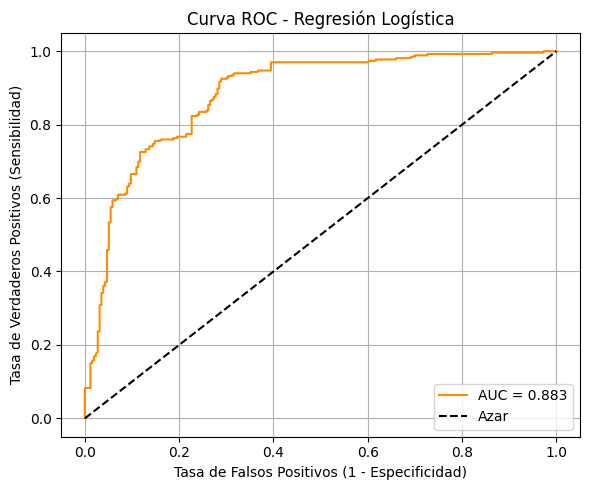

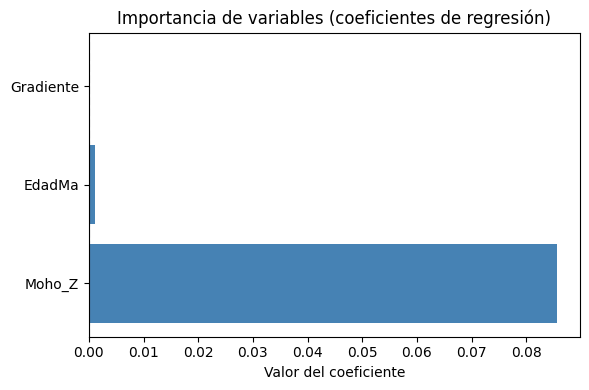

In [48]:
import matplotlib.pyplot as plt
from sklearn.metrics import roc_curve

# === Curva ROC ===
fpr, tpr, thresholds = roc_curve(y_test, y_prob)

plt.figure(figsize=(6, 5))
plt.plot(fpr, tpr, label=f"AUC = {auc:.3f}", color="darkorange")
plt.plot([0, 1], [0, 1], "k--", label="Azar")
plt.xlabel("Tasa de Falsos Positivos (1 - Especificidad)")
plt.ylabel("Tasa de Verdaderos Positivos (Sensibilidad)")
plt.title("Curva ROC - Regresión Logística")
plt.legend(loc="lower right")
plt.grid(True)
plt.tight_layout()
plt.show()

# === Coeficientes del modelo (importancia de variables) ===
plt.figure(figsize=(6, 4))
variables = ["Moho_Z", "EdadMa", "Gradiente"]
plt.barh(variables, coef, color="steelblue")
plt.xlabel("Valor del coeficiente")
plt.title("Importancia de variables (coeficientes de regresión)")
plt.axvline(0, color="gray", linestyle="--")
plt.tight_layout()
plt.show()


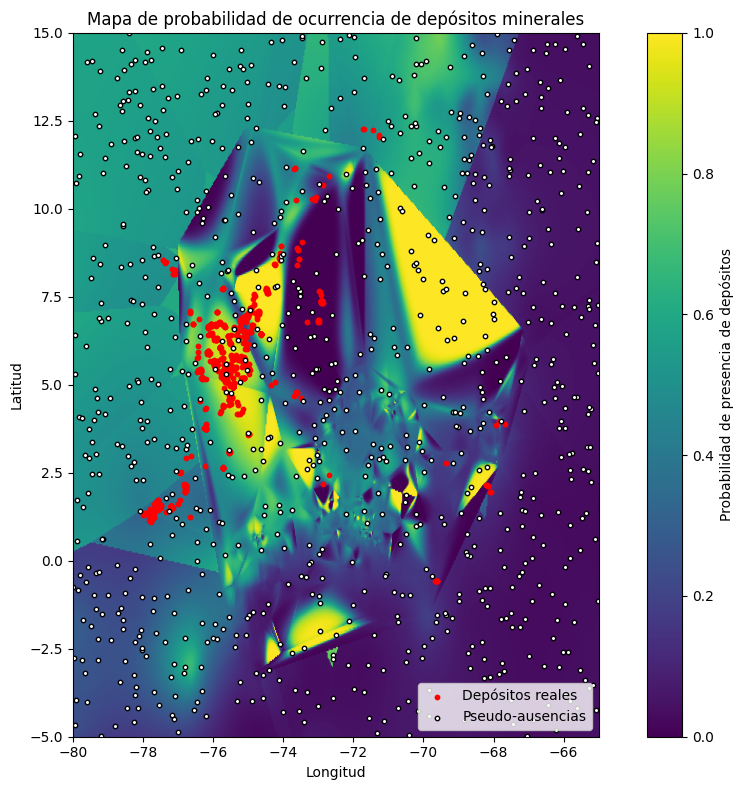

In [49]:
import matplotlib.pyplot as plt

# === Aplanar las grillas para preparar predicción espacial ===
grid_points = np.c_[grid_moho.ravel(), grid_edad.ravel(), grid_grad.ravel()]

# === Predecir probabilidades para cada celda ===
grid_prob = model.predict_proba(grid_points)[:, 1]
grid_prob = grid_prob.reshape(grid_moho.shape)

# === Crear figura ===
plt.figure(figsize=(10, 8))
prob_plot = plt.imshow(
    grid_prob,
    extent=(-80, -65, -5, 15),
    origin="lower",
    cmap="viridis",
    vmin=0, vmax=1,
)
plt.colorbar(prob_plot, label="Probabilidad de presencia de depósitos")

# === Superponer puntos reales y pseudo-ausencias ===
gdf_total[gdf_total["Presencia"] == 1].plot(ax=plt.gca(), color="red", markersize=10, label="Depósitos reales")
gdf_total[gdf_total["Presencia"] == 0].plot(ax=plt.gca(), color="white", edgecolor="black", markersize=10, label="Pseudo-ausencias")

plt.xlabel("Longitud")
plt.ylabel("Latitud")
plt.title("Mapa de probabilidad de ocurrencia de depósitos minerales")
plt.legend()
plt.tight_layout()
plt.show()


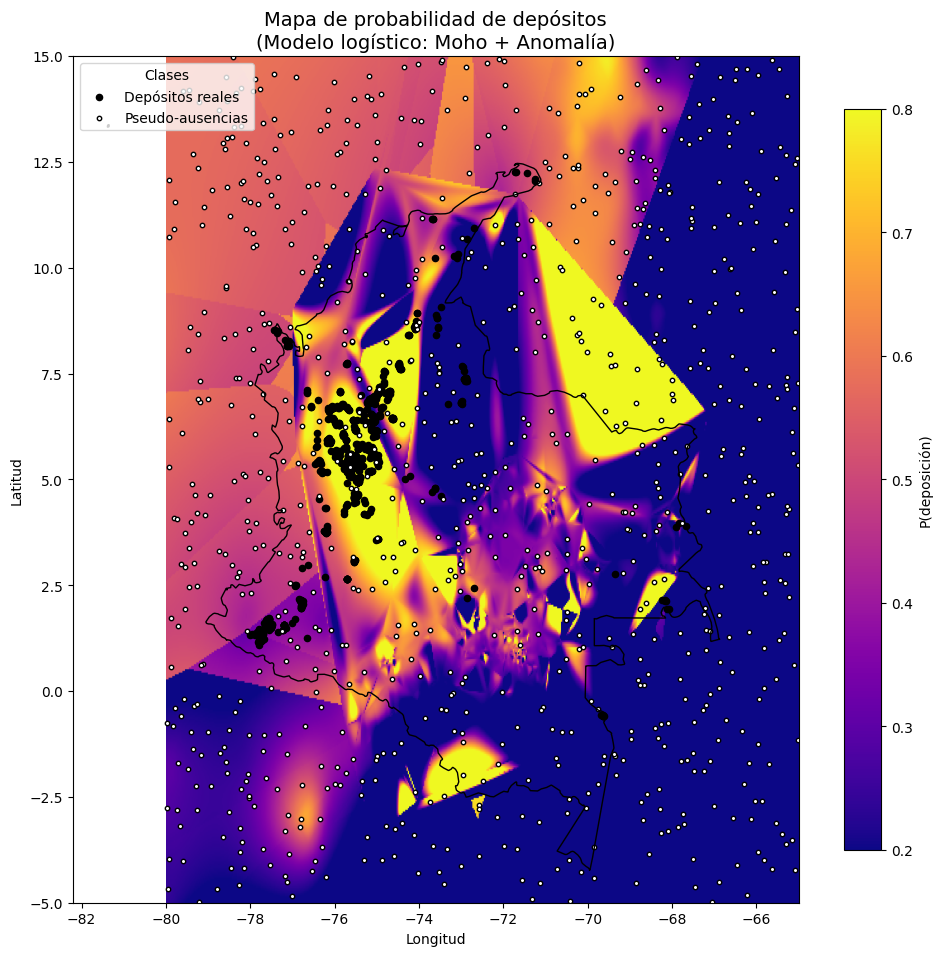

In [50]:
import matplotlib.pyplot as plt
import geopandas as gpd
import numpy as np

# === Aplanar y predecir probabilidades ===
grid_points = np.c_[grid_moho.ravel(), grid_edad.ravel(), grid_grad.ravel()]
grid_prob = model.predict_proba(grid_points)[:, 1].reshape(grid_moho.shape)

# === Cargar shapefile de Colombia ===
area_col = gpd.read_file("C:/Git_SCA/AGE/Area_Col").to_crs(epsg=4326)

# === Crear figura ===
fig, ax = plt.subplots(figsize=(10, 10))

# === Mostrar grilla de probabilidades ===
img = ax.imshow(
    np.flipud(grid_prob),  # Soluciona el giro de 180 grados
    extent=(-80, -65, -5, 15),
    origin="upper",
    cmap="plasma",
    vmin=0.2, vmax=0.8
)

# === Colorbar ===
cbar = plt.colorbar(img, ax=ax, shrink=0.8)
cbar.set_label("P(deposición)")

# === Dibujar contorno del país ===
area_col.boundary.plot(ax=ax, edgecolor="black", linewidth=1)

# === Dibujar puntos ===
gdf_total[gdf_total["Presencia"] == 1].plot(ax=ax, color="black", markersize=20, label="Depósitos reales")
gdf_total[gdf_total["Presencia"] == 0].plot(ax=ax, facecolor="white", edgecolor="black", markersize=10, label="Pseudo-ausencias")

# === Títulos ===
plt.title("Mapa de probabilidad de depósitos\n(Modelo logístico: Moho + Anomalía)", fontsize=14)

# === Leyenda personalizada ===
ax.legend(
    title="Clases",
    loc="upper left",
    frameon=True,
    facecolor="white"
)

# === Ajustes finales ===
ax.set_xlabel("Longitud")
ax.set_ylabel("Latitud")
plt.tight_layout()
plt.show()
